In [1]:
import torch 
from dataloader import ECG_Data, prepare_dataset
from resnet_1d import SERes1d
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda")  # Set device to GPU
else:
    print("CUDA is not available. Training on CPU.")
    device = torch.device("cpu")  # Set device to CPU

CUDA is available!


In [8]:
def training_loop(model:torch.nn.Module,
                  optimizer,
                  criterion,
                  scheduler,
                  train_loader:torch.utils.data.DataLoader,
                  validation_loader:torch.utils.data.DataLoader,
                  epochs:int = 100,
                  save_path:str = None,
                  )-> tuple :
    
    '''
    Training loop for the model
    Documentation TBA
    TODO: Add early stopping
    '''

    train_losses = np.array([])
    train_accuracies = np.array([])
    val_losses = np.array([])
    val_accuracies = np.array([])
    best_acc = 0.0
    for epoch in range(epochs):
        running_loss = 0.0
        train_acc = 0.0
        model.train()
        epoch_start = time.time()
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = criterion(out, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_acc += torch.sum(torch.sigmoid(out).argmax(dim=1) == label)
            running_loss += loss.item()*data.size(0)
        if scheduler != None:
            scheduler.step()
        epoch_end = time.time()
        train_accuracies = np.append(train_accuracies,train_acc.cpu()/len(train_loader.dataset))
        train_losses = np.append(train_losses, running_loss/len(train_loader.dataset))
        epoch_time = epoch_end - epoch_start
        print(f'Epoch:{epoch}\n-----------Training------------- \n Loss:{train_losses[epoch]}, accuracy:{train_accuracies[epoch]}, epoch time:{epoch_time:.2f}')

        model.eval()
        val_acc = 0.0
        val_running_loss = 0.0
        for data,label in validation_loader:
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = criterion(out, label)
            val_acc += torch.sum(torch.sigmoid(out).argmax(dim=1) == label)
            val_running_loss += loss.item()*data.size(0)
            if save_path is not None:
                if val_acc > best_acc:
                    torch.save(model.state_dict(), save_path)
                    best_acc = val_acc
        val_accuracies = np.append(val_accuracies,val_acc.cpu()/len(validation_loader.dataset))
        val_losses = np.append(val_losses, val_running_loss/len(validation_loader.dataset))
        print(f'--------------Validation -------- \n  Loss:{val_losses[epoch]}, accuracy:{val_accuracies[epoch]}')

    return (val_accuracies,val_losses),(train_accuracies,train_losses)

In [9]:

# final_data=prepare_dataset(".\\sample_dataset\\ptbxl_database.csv")
final_data=prepare_dataset(r"/home/wicia/Documents/Horzyk/resnet_project/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv")


    #split zrobiłem sklearnem bo po co się męczyć
ECG_train,ECG_test=train_test_split(final_data,test_size=0.2,random_state=42)

    #inaczej nie działa xd
ECG_train=ECG_train.reset_index()
ECG_test=ECG_test.reset_index()
    #tu ważne żeby podać ścieżkę do folderu z danymi, ale tylko folderu, bo potem to już się samo sklei
train_dataset=ECG_Data(ECG_train, r"/home/wicia/Documents/Horzyk/resnet_project/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/", augmentation_probability=0.2, noise_probability=0.2, noise_level=0.05)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=256,num_workers=4)
test_dataset=ECG_Data(ECG_test, r"/home/wicia/Documents/Horzyk/resnet_project/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/")
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=256,num_workers=4)


In [5]:
print(train_dataset[0][1])
count = np.zeros(6)
for i in range(len(train_dataset)):
    count[train_dataset[i][1]] += 1
print(count)

1
[7587. 9789.    0.    0.    0.    0.]


In [6]:
print(np.sum(count))

17376.0


In [7]:
weights = torch.Tensor(1-(count/len(train_dataset))).to(device)

In [10]:
number_of_channels=12
number_of_classes=2
model = SERes1d(number_of_channels,number_of_classes).to(device)

In [11]:
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
number_of_epochs = 30


In [12]:
val_history,train_history = training_loop(model,
                                          optimizer,
                                          criterion,
                                          scheduler,
                                          train_loader,
                                          test_loader,
                                          number_of_epochs,
                                          save_path="best_SEresnet_model.pth")

/home/wicia/Documents/Horzyk/resnet_project/.venv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch:0
-----------Training------------- 
 Loss:0.46578012952927506, accuracy:0.7901703715324402, epoch time:13.79
--------------Validation -------- 
  Loss:0.4087627281470852, accuracy:0.8404695987701416
Epoch:1
-----------Training------------- 
 Loss:0.36042253253209655, accuracy:0.8378798365592957, epoch time:13.95
--------------Validation -------- 
  Loss:0.3628841987082093, accuracy:0.8485267162322998
Epoch:2
-----------Training------------- 
 Loss:0.3297712203547441, accuracy:0.8505409955978394, epoch time:14.08
--------------Validation -------- 
  Loss:0.310969281866186, accuracy:0.8664824962615967
Epoch:3
-----------Training------------- 
 Loss:0.31642992830188676, accuracy:0.8596915006637573, epoch time:13.36
--------------Validation -------- 
  Loss:0.3053119172707447, accuracy:0.8699355721473694
Epoch:4
-----------Training------------- 
 Loss:0.31030400434910266, accuracy:0.8611302971839905, epoch time:14.50
--------------Validation -------- 
  Loss:0.3306968714321516, accur

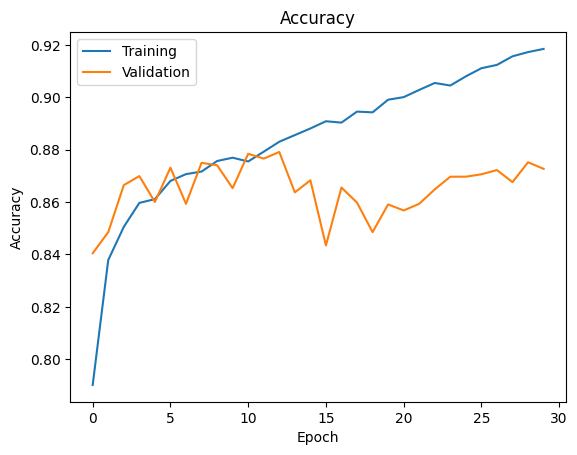

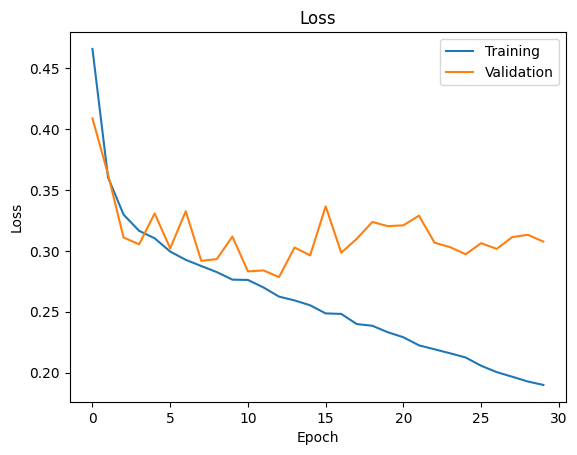

In [13]:
plt.plot(train_history[0])
plt.plot(val_history[0])
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training","Validation"])
plt.show()
plt.plot(train_history[1])
plt.plot(val_history[1])
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training","Validation"])
plt.show()

In [36]:
model.eval()
accuracy = 0
for data,label in test_loader :
    data = data.to(device)
    out = model(data)
    accuracy += torch.sum(torch.sigmoid(out).argmax(dim=1) == label.to(device))

accuracy = accuracy/ len(test_loader.dataset)
print(accuracy)

tensor(0.7109, device='cuda:0')
